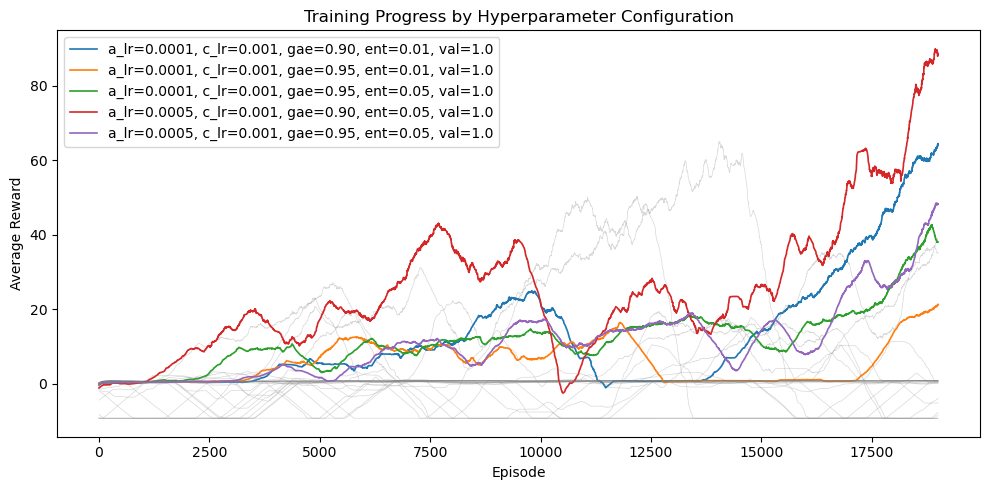


Test Performance:
      a_lr   c_lr   gae   ent  val  mean_R   std_R   max_R  min_R  median_R
1   0.0001  0.001  0.90  0.01  1.0  120.49  146.38  1956.1   -0.2     61.25
19  0.0005  0.001  0.90  0.05  1.0  118.70  143.95  1529.5    1.0     64.35
23  0.0005  0.001  0.95  0.05  1.0   48.00   62.30   481.4    1.6     24.80
5   0.0001  0.001  0.95  0.01  1.0   36.85   39.95   315.6    1.2     22.80
7   0.0001  0.001  0.95  0.05  1.0   16.89   23.35   326.3   -0.9     11.00
6   0.0001  0.001  0.95  0.05  0.5    6.64    8.01    97.6    0.4      4.90
0   0.0001  0.001  0.90  0.01  0.5    0.80    0.00     0.8    0.8      0.80
15  0.0001  0.005  0.95  0.05  1.0    0.80    0.00     0.8    0.8      0.80
29  0.0005  0.005  0.95  0.01  1.0    0.80    0.00     0.8    0.8      0.80
28  0.0005  0.005  0.95  0.01  0.5    0.80    0.00     0.8    0.8      0.80
27  0.0005  0.005  0.90  0.05  1.0    0.80    0.00     0.8    0.8      0.80
21  0.0005  0.001  0.95  0.01  1.0    0.80    0.00     0.8    0.8    

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np

def analyze_parameter_impact(test_res):
   data = []
   param_names = ['a_lr', 'c_lr', 'gae', 'ent', 'val']
   
   for exp_key, rewards in test_res.items():
       # 파라미터 파싱
       params = {}
       for param in param_names:
           start_idx = exp_key.find(param)
           if start_idx != -1:
               value_start = start_idx + len(param) + 1
               value_end = exp_key.find('_', value_start)
               if value_end == -1:
                   value_end = len(exp_key)
               value = float(exp_key[value_start:value_end])
               params[param] = value
       
       mean_reward = np.mean(rewards)
       
       result = {
           'a_lr': params['a_lr'],
           'c_lr': params['c_lr'],
           'gae': params['gae'],
           'ent': params['ent'],
           'val': params['val'],
           'mean_R': mean_reward
       }
       data.append(result)
   
   return pd.DataFrame(data)

def analyze_results(exp_res, test_res):
   data = []
   param_names = ['a_lr', 'c_lr', 'gae', 'ent', 'val']
   
   for exp_key in exp_res.keys():
       # 파라미터 파싱
       params = {}
       for param in param_names:
           start_idx = exp_key.find(param)
           if start_idx != -1:
               value_start = start_idx + len(param) + 1
               value_end = exp_key.find('_', value_start)
               if value_end == -1:
                   value_end = len(exp_key)
               value = float(exp_key[value_start:value_end])
               params[param] = value
       
       # 성능 계산
       train_rewards = exp_res[exp_key]
       train_final_mean = np.mean(train_rewards[-1000:])
       
       test_rewards = test_res[exp_key]
       test_mean = np.mean(test_rewards)
       test_std = np.std(test_rewards)
       
       overall_score = test_mean - 0.5 * test_std
       
       result = {
           'a_lr': params['a_lr'],
           'c_lr': params['c_lr'],
           'gae': params['gae'],
           'ent': params['ent'],
           'val': params['val'],
           'train_final_mean': train_final_mean,
           'test_mean': test_mean,
           'test_std': test_std,
           'overall_score': overall_score
       }
       data.append(result)
   
   return pd.DataFrame(data).sort_values('overall_score', ascending=False)

def plot_training_curves(exp_res):
   param_names = ['a_lr', 'c_lr', 'gae', 'ent', 'val']
   plt.figure(figsize=(10, 5))
   
   # 특별히 강조할 인덱스들 [ 1,5,6,7,19,23]
   highlight_indices = [1, 5, 7, 19, 23]
   
   for idx, (exp_key, rewards) in enumerate(exp_res.items()):
       # 파라미터 파싱
       params = {}
       for param in param_names:
           start_idx = exp_key.find(param)
           if start_idx != -1:
               value_start = start_idx + len(param) + 1
               value_end = exp_key.find('_', value_start)
               if value_end == -1:
                   value_end = len(exp_key)
               value = float(exp_key[value_start:value_end])
               params[param] = value
       
       # 이동 평균으로 스무딩
       win_size=1000
       smoothed_rewards = np.convolve(rewards, np.ones(win_size)/win_size, mode='valid')
       
       if idx in highlight_indices:
           # 강조할 그래프
           label = f"a_lr={params['a_lr']:.4f}, c_lr={params['c_lr']:.3f}, gae={params['gae']:.2f}, ent={params['ent']:.2f}, val={params['val']:.1f}"
           plt.plot(smoothed_rewards, label=label, linewidth=1.2)
       else:
           # 희미한 그래프
           plt.plot(smoothed_rewards, color='gray', alpha=0.3, linewidth=0.5)
   
   plt.xlabel('Episode')
   plt.ylabel('Average Reward')
   plt.title('Training Progress by Hyperparameter Configuration')
   plt.legend(bbox_to_anchor=(0, 1), loc='upper left')
   plt.tight_layout()
   plt.show()
   
  
def recommend_best_configuration(exp_res, test_res):
    data = []
    param_names = ['a_lr', 'c_lr', 'gae', 'ent', 'val']
    
    for exp_key in exp_res.keys():
        # 파라미터 파싱
        params = {}
        for param in param_names:
            start_idx = exp_key.find(param)
            if start_idx != -1:
                value_start = start_idx + len(param) + 1
                value_end = exp_key.find('_', value_start)
                if value_end == -1:
                    value_end = len(exp_key)
                value = float(exp_key[value_start:value_end])
                params[param] = value
        
        # 성능 지표 계산
        train_final_mean = np.mean(exp_res[exp_key][-1000:])
        test_mean = np.mean(test_res[exp_key])
        test_std = np.std(test_res[exp_key])
        score = test_mean - test_std * 0.5
        
        # 결과 저장
        result = {
            'a_lr': params['a_lr'],
            'c_lr': params['c_lr'],
            'gae': params['gae'],
            'ent': params['ent'],
            'val': params['val'],
            'tr_fin_mean': train_final_mean,
            'test_mean': test_mean,
            'test_std': test_std.round(2),
            'score': score.round(2)
        }
        data.append(result)
    
    # DataFrame 생성 및 정렬
    df = pd.DataFrame(data)
    return df.sort_values('score', ascending=False)

def analyze_test_performance(test_res):
   data = []
   param_names = ['a_lr', 'c_lr', 'gae', 'ent', 'val']
   
   for exp_key, rewards in test_res.items():
       # 파라미터 파싱
       params = {}
       for param in param_names:
           start_idx = exp_key.find(param)
           if start_idx != -1:
               value_start = start_idx + len(param) + 1
               value_end = exp_key.find('_', value_start)
               if value_end == -1:
                   value_end = len(exp_key)
               value = float(exp_key[value_start:value_end])
               params[param] = value

       metrics = {
           'a_lr': params['a_lr'],
           'c_lr': params['c_lr'],
           'gae': params['gae'],
           'ent': params['ent'],
           'val': params['val'],
           'mean_R': np.mean(rewards).round(2),
           'std_R': np.std(rewards).round(2),
           'max_R': np.max(rewards),
           'min_R': np.min(rewards),
           'median_R': np.median(rewards)
       }
       data.append(metrics)
   
   return pd.DataFrame(data).sort_values('mean_R', ascending=False)

def analyze_training_stability(exp_res):
   data = []
   param_names = ['a_lr', 'c_lr', 'gae', 'ent', 'val']
   
   for exp_key, rewards in exp_res.items():
       # 파라미터 파싱
       params = {}
       for param in param_names:
           start_idx = exp_key.find(param)
           if start_idx != -1:
               value_start = start_idx + len(param) + 1
               value_end = exp_key.find('_', value_start)
               if value_end == -1:
                   value_end = len(exp_key)
               value = float(exp_key[value_start:value_end])
               params[param] = value
               
       # 마지막 1000 에피소드의 보상 분석
       final_rewards = rewards[-1000:]
       
       # 수렴 속도 계산 (최종 평균의 90%에 도달하는 시점)
       final_mean = np.mean(final_rewards)
       threshold = 0.9 * final_mean
       convergence_point = np.argmax(rewards > threshold)
       stab_score=final_mean / (np.std(final_rewards) + 1e-8)
       
       metrics = {
           'a_lr': params['a_lr'],
           'c_lr': params['c_lr'],
           'gae': params['gae'],
           'ent': params['ent'],
           'val': params['val'],
           'fin_mean': final_mean,
           'fin_std': np.std(final_rewards).round(2),
           'conv_epi': convergence_point,
           'stab_score': format(stab_score, '.2e') # 안정성 점수
       }
       data.append(metrics)
   
   return pd.DataFrame(data).sort_values('stab_score', ascending=False)


# 결과 로드
with open("ac32_exp_res.pkl", "rb") as f:
    exp_res = pickle.load(f)
with open("ac32_test_res.pkl", "rb") as f:
    test_res = pickle.load(f)

# 분석 실행
plot_training_curves(exp_res)
print("\nTest Performance:")
print(analyze_test_performance(test_res))
print("\nTraining Stability:")
print(analyze_training_stability(exp_res))
print("\nParameter Impact:")
print(analyze_parameter_impact(test_res))
print("\nRecommended Configurations:")
print(recommend_best_configuration(exp_res, test_res))

In [2]:
len(exp_res)

32